In [1]:
# Find the room temperature by fitting an exponential to the data and analyzing the intercept

## Imports

In [2]:
import os
import sys
import json
import warnings
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), '../'))
from utils import *
from preprocessing.preprocessing_utils import build_df
from analysis_utils import searchc

from scipy.optimize import curve_fit, OptimizeWarning
warnings.simplefilter("error", OptimizeWarning)

from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, WhiteKernel, RationalQuadratic
from sklearn.preprocessing import MinMaxScaler

config = load_config()
sys.path.append(config['PATH_MISC'])
from misc import create_errorbar_densities, gpartconv1d

## Data

In [3]:
# Load the data
df = build_df(verbose=True)

Checking if all the files have enough leading zeros...
Ensuring all the files have enough leading zeros...


Preprocessing files using 8 workers: 100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


Saving dataframe fragments...


Saving: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


Reading dataframe fragments...


Reading: 100%|██████████| 18/18 [00:34<00:00,  1.90s/it]


The "Timestamp" column is not sorted. Sorting...
Sorting done. (1.1s)
Resetting index...
Index reset. (2.1s)
8 columns have nan values:
- Read Activity [%].3
- Write Activity [%].3
- Total Activity [%].3
- Read Rate [MB/s].3
- Write Rate [MB/s].3
- Read Total [MB].3
- iGPU [V]
- Write Total [MB].1
Dropped 8 columns with nan values
No nan values in the Interval column.
Updating weather data...
Loading weather dataframe
Requested end date (1654899687) is more than one hour after the last stored date (1654783200). Updating weather dataframe
30 line(s) added. Writing weather dataframe
Weather dataframe updated
Weather data updated. (0.4s)


In [4]:
# Recorded bios times in seconds (i.e. time between actual system start and actual measurement start)
# The file contains two series of measurements, one for 'boot' and one for 'wake'
with open(config['FILE_BIOS_TIME']) as f:
    bios_time_samples = json.load(f)

# Convert the lists into numpy arrays
for key in bios_time_samples.keys():
    bios_time_samples[key] = np.array(bios_time_samples[key])

## Objective

In [5]:
# We fit an exponential function to the Liquid Temperature at the start of each measurement
# The exponential function is defined as:
# y = c - a * exp(-b * x)
# Where:
# a = Difference between Initial Temperature and Saturation Temperature
# b = Temperature Decay Rate
# c = Saturation Temperature

In [6]:
# Define the function to fit
def exponential_fit(x, a, b, c):
    return c - a * np.exp(-b * x)

## Preprocessing

### Parameters

In [7]:
# Minutes after the start of measurement to fit the exponential
saturation_time_minutes = 70

# Seconds to skip from the beginning of the measurement if the data is too noisy in the beginning
noisy_startup_seconds = 45

# Maximum residual below which the fit is considered successful
critical_residual = 0.6

# Minutes after the start of measurement to fit the exponential from
min_fit_minutes = 10

# Rate of adaptation of the right fit boundary to the proposed boundary in each iteration
alpha = 0.5

# Maximum allowed saturation temperature
max_sensible_saturation_temp = 40

# Limit for the maximum standard deviation of the differences in the first 2 * noisy_startup_seconds seconds
std_limit_2_noisy_startup_seconds = 0.055

# Maximum MSE to be considered a successful fit
max_good_mse = 0.2

In [8]:
# Find the row indices after pauses (i.e. when a new measurement is started)
# Use the 'Interval' column, which is the time between measurements
# A pause is defined as a time interval of more than 2 hours
# This ensures that the temperature is not affected by the previous measurement
# Increment each pause index by 1 to get the index of the next measurement
raw_pause_indices = np.where(df['Interval'] > 2 * 3600)[0] + 1

In [9]:
# Remove pause indices that do not have enought data between them
# Othwerwise, the fits will result in duplicate values
data_between_raw_pause_indices = np.diff(raw_pause_indices)

In [10]:
# Remove the indices that have less than min_fit_minutes between them
pause_indices = raw_pause_indices[:-1][data_between_raw_pause_indices >= min_fit_minutes*60*2]

# Add the last pause index, if the difference between the length of the dataset and the last pause index is greater than min_fit_minutes
if len(df) - raw_pause_indices[-1] > min_fit_minutes:
    pause_indices = np.append(pause_indices, raw_pause_indices[-1])

In [11]:
print(f'Removed {len(raw_pause_indices) - len(pause_indices)} pauses due to insufficient data')

Removed 9 pauses due to insufficient data


In [12]:
fit_temperatures = [np.array(df.loc[pause_index:pause_index + saturation_time_minutes * 60 * 2, 'Liquid Temperature [°C]']) for pause_index in pause_indices]
global_temperature_err = 0.5

for i, fit_temperature in enumerate(fit_temperatures):
    if abs(fit_temperature[0] - fit_temperature[1]) > 0.2:
        fit_temperatures[i] = fit_temperature[1:]

### Truncate

In [13]:
# Determine the limit from which to start the fit, should the beginning of the measurement be noisy
diff_stds_in_2_noisy_startup_seconds_list = np.zeros(pause_indices.size)
for i in tqdm(range(pause_indices.size)):   
    # Compute the changes in temperature at the beginning of the measurement
    y_diff = np.diff(fit_temperatures[i])

    # Compute the standard deviation of the differences in the first 2*noisy_startup_seconds seconds
    diff_stds_in_2_noisy_startup_seconds_list[i] = np.std(y_diff[:2 * 2 * noisy_startup_seconds])

100%|██████████| 80/80 [00:00<00:00, 26689.81it/s]


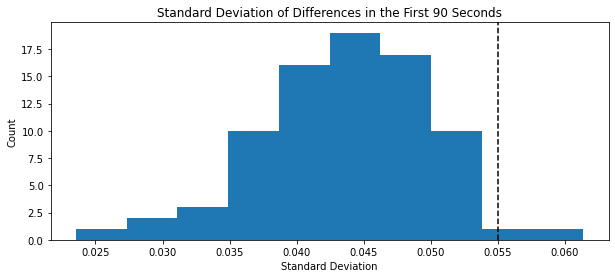

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(diff_stds_in_2_noisy_startup_seconds_list, bins='auto');
ax.axvline(std_limit_2_noisy_startup_seconds, color='k', linestyle='--')
ax.set_title(f'Standard Deviation of Differences in the First {2*noisy_startup_seconds} Seconds')
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Count');

## Fitting Procedure

In [15]:
# Conduct the fits
# Include data up to saturation_time_minutes minutes from the beginning of the measurement

# Initialize the arrays to store the fit parameters
a, b, c, a_err, b_err, c_err, mse = [np.empty(pause_indices.size) for _ in range(7)]
removed_before_list = np.zeros(pause_indices.size, dtype=int)
removed_after_list = np.zeros(pause_indices.size, dtype=int)

for i in tqdm(range(pause_indices.size)):
    y = np.array(fit_temperatures[i])
    
    # Check if the standard deviation in the first m seconds exceeds the limit
    if diff_stds_in_2_noisy_startup_seconds_list[i] > std_limit_2_noisy_startup_seconds:
        # Ignore the first m seconds
        y = y[noisy_startup_seconds * 2:]
        removed_before_list[i] += noisy_startup_seconds * 2

    # Detect sudden drops in temperature and remove them
    # The sudden drop is defined as a drop of more than 3°C over 10 instances
    y_diff_over_10 = y[10:] - y[:-10]
    sudden_drop_indices = np.where(y_diff_over_10 < -3)[0]
    if len(sudden_drop_indices) > 0:
        removed_after_list[i] += len(y) - (sudden_drop_indices[0] - 5)
        y = y[:sudden_drop_indices[0] - 5]

    # Detect the first point where the temperature is rising
    y_diff_rolling_average = np.convolve(np.diff(y), np.ones((50,)) / 50, mode='valid')
    rising_indices = np.where(y_diff_rolling_average > 0)[0]
    if len(rising_indices) > 0 and rising_indices[0] < 500:
        y = y[rising_indices[0]:]
        removed_before_list[i] += rising_indices[0]

    x = np.arange(len(y))
    fit_not_good_enough = True
    while fit_not_good_enough:
        # Fit the data
        try:
            popt, pcov = curve_fit(exponential_fit, x, y, p0=[y[0], 0.001, y[-1]], sigma=np.full(len(x), global_temperature_err), maxfev=1000000)
        except OptimizeWarning:
            # Ignore the exception
            ...

        # Compute the R^2 value
        residuals = y - exponential_fit(x, *popt)

        # If the length of the time series is shorter than min_fit_minutes minutes, end the fit
        if len(residuals) <= min_fit_minutes * 60 * 2:    
            fit_not_good_enough = False
            break

        # If the residuals
        if np.max(np.abs(residuals[min_fit_minutes * 60 * 2:])) > critical_residual:
            # Determine the index of the first residual that exceeds critical_residual°C
            strict_fit_up_to_target = np.where(np.abs(residuals[min_fit_minutes * 60 * 2:]) > critical_residual)[0][0] + min_fit_minutes * 60 * 2

            fit_up_to_target = int(alpha * strict_fit_up_to_target + (1 - alpha) * len(y))

            # Limit fit_up_to_target to a minimum of min_fit_minutes minutes
            if fit_up_to_target <= min_fit_minutes * 60 * 2:
                fit_up_to_target = min_fit_minutes * 60 * 2
                fit_not_good_enough = False

            removed_after_list[i] += max(0, len(y) - fit_up_to_target)
            x = x[:fit_up_to_target]
            y = y[:fit_up_to_target]
        elif popt[2] > max_sensible_saturation_temp:
            # Reduce the length by 10%
            removed_after_list[i] += int(len(y) * 0.1)
            
            x = x[:int(len(x) * 0.9)]
            y = y[:int(len(y) * 0.9)]
        else:
            fit_not_good_enough = False
    
    mse[i] = np.mean(residuals ** 2)

    # Store the fit parameters and their errors
    a[i], b[i], c[i] = popt
    a_err[i], b_err[i], c_err[i] = np.sqrt(np.abs(np.diag(pcov)))

100%|██████████| 80/80 [00:05<00:00, 14.83it/s]


### Filter 1: Residuals, Saturation Temperature

In [16]:
filter1_mask = (mse < max_good_mse) & (c < max_sensible_saturation_temp)

## Plot

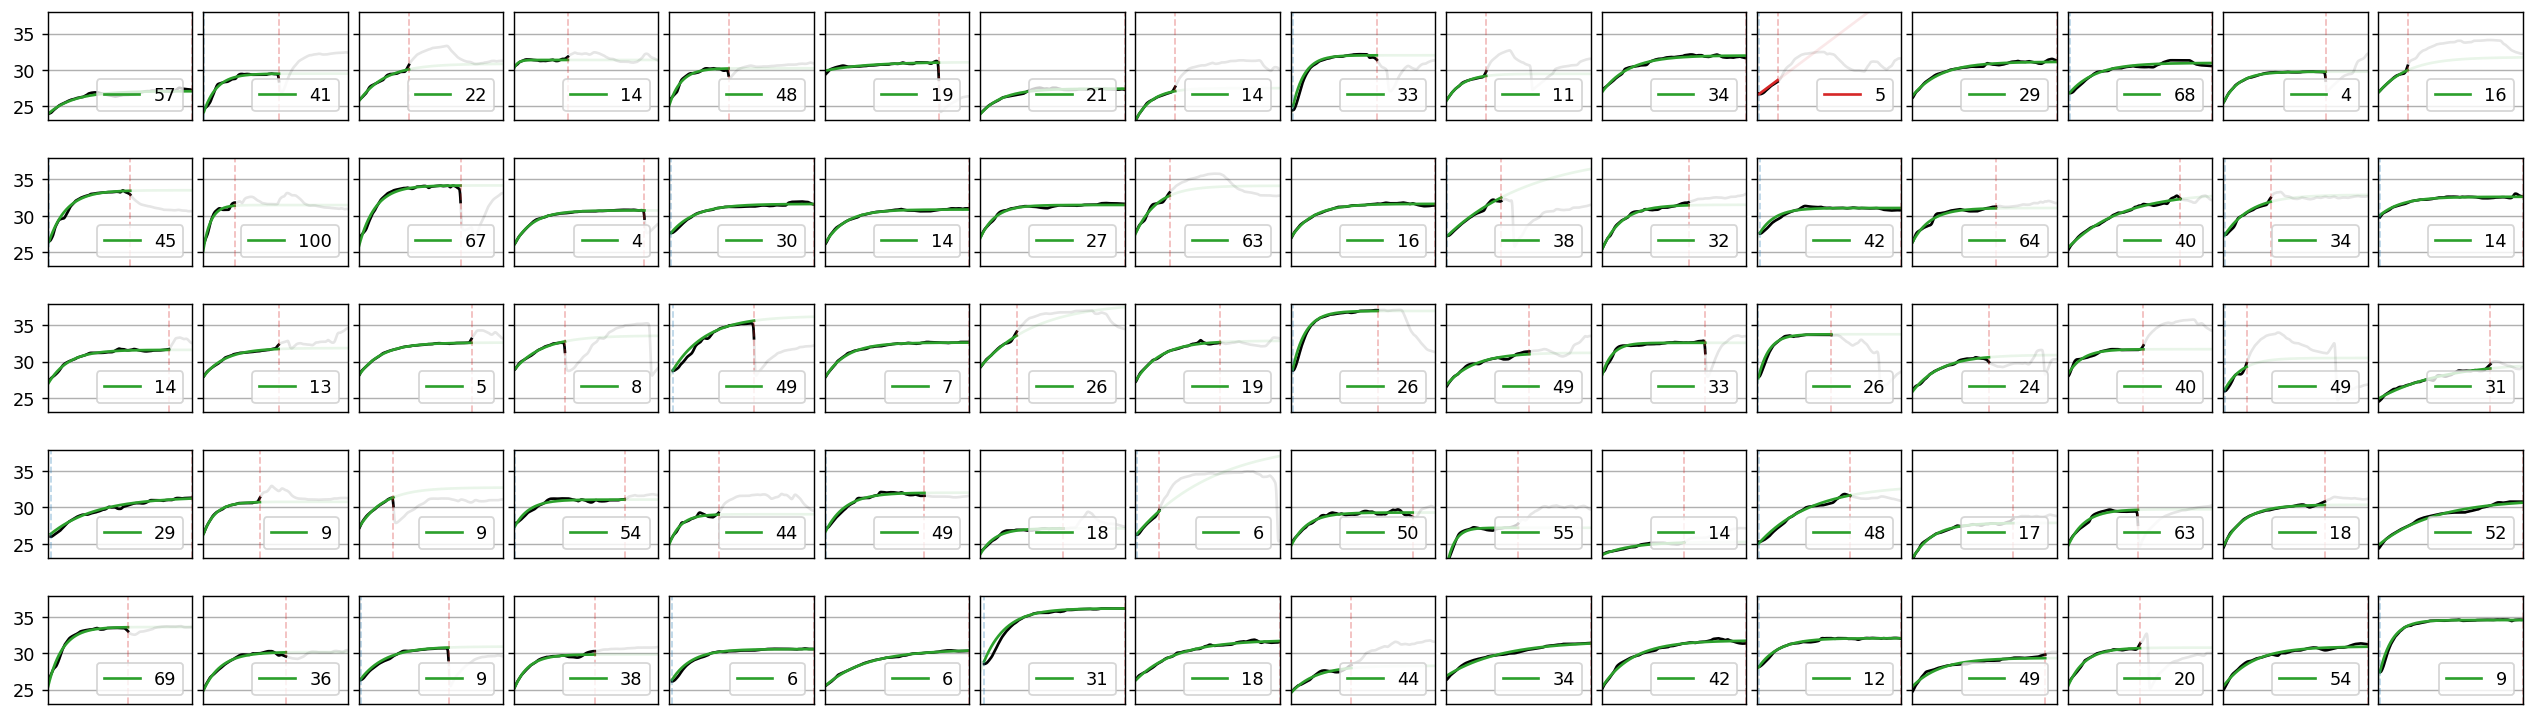

In [17]:
# Define the target aspect ratio of the figure
aspect_ratio = 3

# Find the optimal number of rows and columns for the figure, such that columns * rows = pause_indices.size and columns / rows = aspect_ratio
ROWS = int(np.round(np.sqrt(pause_indices.size / aspect_ratio)))
COLS = int(np.ceil(pause_indices.size / ROWS))

# Plot the fits
fig, axes = plt.subplots(ROWS, COLS, figsize=(20, int(np.round(20/COLS*ROWS))), dpi=128)
fig.tight_layout(h_pad=0, w_pad=-2)

for i, ax in zip(range(len(pause_indices)), axes.flatten()):
    # Highlight the fits where the R^2 value is above r_good
    color = 'tab:green' if filter1_mask[i] else 'tab:red'

    y = gpartconv1d(fit_temperatures[i], sigma=2*20)

    # Indicate the range of the fit with different alpha
    ax.plot(y, 'k', alpha=0.1)
    ax.plot(np.arange(removed_before_list[i], len(y)-removed_after_list[i]), y[removed_before_list[i]:len(y)-removed_after_list[i]], 'k', alpha=1)

    ax.plot(exponential_fit(np.arange(0, saturation_time_minutes * 60 * 2 +1), a[i], b[i], c[i]), color=color, alpha=0.1)
    ax.plot(np.arange(removed_before_list[i], len(y)-removed_after_list[i]), exponential_fit(np.arange(removed_before_list[i], len(y)-removed_after_list[i]), a[i], b[i], c[i]), color=color, alpha=1, label=int(mse[i]*1e3))
    
    ax.axvline(x=removed_before_list[i], color='tab:blue', linestyle='--', alpha=0.3, linewidth=1)
    ax.axvline(x=len(y)-removed_after_list[i], color='tab:red', linestyle='--', alpha=0.3, linewidth=1)

    ax.set_xlim(0, saturation_time_minutes * 60 * 2)
    ax.set_ylim(23, 38)
    ax.set_xticks([])
    ax.set_yticks([25, 30, 35])
    if i % COLS != 0:
        ax.set_yticklabels([])
    ax.grid(axis='y', zorder=5)
    ax.legend(loc='lower right')
    
# Hide the unused axes
for ax in axes.flatten()[len(pause_indices):]:
    ax.axis('off')

## Boot vs Wake

In [18]:
pause_lengths = np.array(df['Interval'][pause_indices])[filter1_mask]
physical_memory_startup = np.array(df['Physical Memory Load [%]'][pause_indices])[filter1_mask]

# Find the distribution of physical memory usage directly after freshly booting the system
physical_memory_boot_mean = np.mean(physical_memory_startup[pause_lengths > 3e4])
physical_memory_boot_std = np.std(physical_memory_startup[pause_lengths > 3e4])

startup_is_wake_mask = physical_memory_startup > physical_memory_boot_mean + physical_memory_boot_std * 3

print(f'Physical memory usage after booting: ({physical_memory_boot_mean:.1f} ± {physical_memory_boot_std:.1f}) %')

Physical memory usage after booting: (10.1 ± 0.5) %


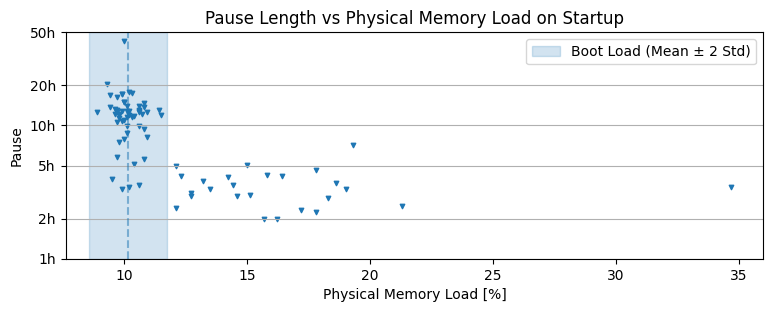

In [19]:
# Scatter the length of the pause between measurements and the room temperature
fig, ax = plt.subplots(figsize=(9, 3), dpi=100)

ax.scatter(np.array(df['Physical Memory Load [%]'][pause_indices])[filter1_mask], np.log(pause_lengths), marker='v', s=10);
xlim_before = ax.get_xlim()

ax.axvline(physical_memory_boot_mean, color='tab:blue', linestyle='--', alpha=0.5);
ax.axvspan(physical_memory_boot_mean - physical_memory_boot_std * 3, physical_memory_boot_mean + physical_memory_boot_std * 3, color='tab:blue', alpha=0.2, label='Boot Load (Mean ± 2 Std)');

ax.set_xlim(xlim_before); ax.legend();
# Set yticks and labels for 1h, 2h, 5h, 10h, 20h, 50h
ax.set_yticks(np.log(60*60*np.array([1, 2, 5, 10, 20, 50]))); ax.set_yticklabels(['1h', '2h', '5h', '10h', '20h', '50h']);
ax.grid(axis='y')
ax.set_ylabel('Pause')
ax.set_xlabel('Physical Memory Load [%]')
ax.set_title('Pause Length vs Physical Memory Load on Startup');

## Bios Time Correction

In [20]:
bios_time_samples_err, bios_time_mean, bios_time_err,  = {}, {}, {}
bios_time_samples_distribution, bios_time_mean_distribution = {}, {}
padding = {'boot': (-10, 2), 'wake': (-2, 2)}
xlim = {}

for startup_type in ['boot', 'wake']:
    bios_time_samples_err[startup_type] = np.full(len(bios_time_samples[startup_type]), 0.5)
    bios_time_mean[startup_type] = np.mean(bios_time_samples[startup_type])
    bios_time_err[startup_type] = np.std(bios_time_samples[startup_type], ddof=1) if len(bios_time_samples[startup_type]) > 1 else 0.5
    
    xlim[startup_type] = (bios_time_samples[startup_type].min() + padding[startup_type][0], bios_time_samples[startup_type].max() + padding[startup_type][1])
    bios_time_samples_distribution[startup_type] = additive_distribution(bios_time_samples[startup_type], bios_time_samples_err[startup_type], xlim=xlim[startup_type])
    bios_time_mean_distribution[startup_type] = additive_distribution([bios_time_mean[startup_type]], [bios_time_err[startup_type]], xlim=xlim[startup_type])

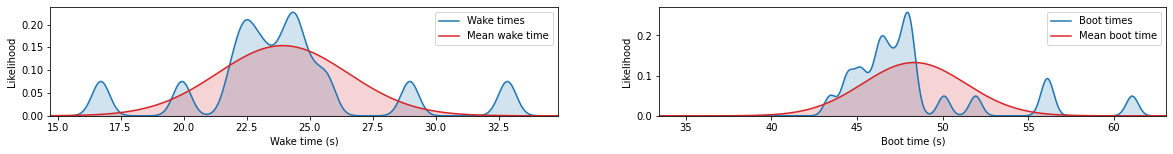

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20, 2))

for ax, startup_type in zip(axes, ['wake', 'boot']):
    startup_type_caps = startup_type[0].upper() + startup_type[1:]
    # Plot the distribution of bios times
    ax.plot(bios_time_samples_distribution[startup_type][0], bios_time_samples_distribution[startup_type][1], 'tab:blue', label=f'{startup_type_caps} times')
    ax.fill_between(bios_time_samples_distribution[startup_type][0], bios_time_samples_distribution[startup_type][1], color='tab:blue', alpha=0.2)
    # Plot the distribution of the mean boot time
    ax.plot(bios_time_mean_distribution[startup_type][0], bios_time_mean_distribution[startup_type][1], 'tab:red', label=f'Mean {startup_type} time')
    ax.fill_between(bios_time_mean_distribution[startup_type][0], bios_time_mean_distribution[startup_type][1], color='tab:red', alpha=0.2)
    
    ax.set_xlabel(f'{startup_type_caps} time (s)'); ax.set_ylabel('Likelihood'); ax.set_xlim(xlim[startup_type]);
    ax.legend(); ax.set_ylim(0, None)

In [22]:
# Redefine ti_good as the initial temperature c - a * exp(-b * bios_time) and apply the filter1_mask
# Consider an additional bios_time seconds of system startup time before the beginning of the measurement (mean of the bios time samples)

# Each row corresponds to 0.5 seconds, so we need to multiply by 2 to get the number of seconds
corrected_bios_time, corrected_bios_time_err = {}, {}
for startup_type in ['boot', 'wake']:
    corrected_bios_time[startup_type] = bios_time_mean[startup_type] * 2
    corrected_bios_time_err[startup_type] = bios_time_err[startup_type] * 2

# If the fit was only done from the first m seconds due to noise, add m seconds to the bios time
corrected_bios_time_with_m, corrected_bios_time_with_m_err = np.empty(len(startup_is_wake_mask)), np.empty(len(startup_is_wake_mask))
for startup_type, mask in zip(['boot', 'wake'], [~startup_is_wake_mask, startup_is_wake_mask]):
    corrected_bios_time_with_m[mask] = (diff_stds_in_2_noisy_startup_seconds_list > std_limit_2_noisy_startup_seconds)[filter1_mask][mask] * noisy_startup_seconds * 2 + corrected_bios_time[startup_type]
    corrected_bios_time_with_m_err[mask] = (diff_stds_in_2_noisy_startup_seconds_list > std_limit_2_noisy_startup_seconds)[filter1_mask][mask] * noisy_startup_seconds * 2 + corrected_bios_time_err[startup_type]

# Saturation temperature
ts_good = c[filter1_mask]
ts_good_err = c_err[filter1_mask]

# Initial temperature
ti_good = ts_good - a[filter1_mask] * np.exp(-b[filter1_mask] * (-corrected_bios_time_with_m))
# Initial temperature uncertainty via gaussian error propagation
ti_good_err = np.sqrt(
    (ts_good_err)**2 # w.r.t to the saturation temperature
    + (a_err[filter1_mask] * (np.exp(-b[filter1_mask] * (-corrected_bios_time_with_m)))**2) # w.r.t a
    + (a[filter1_mask] * b_err[filter1_mask] * (-corrected_bios_time_with_m) * np.exp(-b[filter1_mask] * (-corrected_bios_time_with_m)))**2 # w.r.t b
    + (a[filter1_mask] * b[filter1_mask] * (-corrected_bios_time_with_m_err) * np.exp(-b[filter1_mask] * (-corrected_bios_time_with_m)))**2 # w.r.t. the bios time
)

## Initial and Saturation Temperature

In [23]:
# Perform a linear fit on the saturation and initial temperatures
# Neglect the uncertainty of the saturation temperature
popt, pcov = curve_fit(lambda x, a, b: a + b * x, ts_good, ti_good, sigma=ti_good_err)
intercept, slope = popt
correlation_r2 = 1 - (np.sum((ti_good - (intercept + slope * ts_good)) ** 2) / np.sum((ti_good - np.mean(ti_good)) ** 2))
print(f'Intercept: {intercept:.3f}, Slope: {slope:.3f}, R²: {correlation_r2:.3f}')

Intercept: 9.960, Slope: 0.507, R²: 0.296


In [24]:
# Compute the differences between the initial temperature and the saturation temperature
delta_ts_ti = ts_good - ti_good
delta_ts_ti_err = np.sqrt(
    (ti_good_err)**2 # w.r.t to the initial temperature
    + (ts_good_err)**2 # w.r.t to the saturation temperature
)
xlim = (delta_ts_ti.min() - 1, delta_ts_ti.max() + 1)
delta_ts_ti_distribution = additive_distribution(delta_ts_ti, delta_ts_ti_err, resolution=1000, xlim=xlim, normalize=True)
delta_ts_ti_mean_distribution = additive_distribution([np.mean(delta_ts_ti)], [np.std(delta_ts_ti, ddof=1)], resolution=1000, xlim=xlim, normalize=True)

In [25]:
independent_measurement_min_delta = np.mean(delta_ts_ti) - np.std(delta_ts_ti, ddof=1)
print(f'Independent measurement min delta: {independent_measurement_min_delta:.3f}')

Independent measurement min delta: 3.813


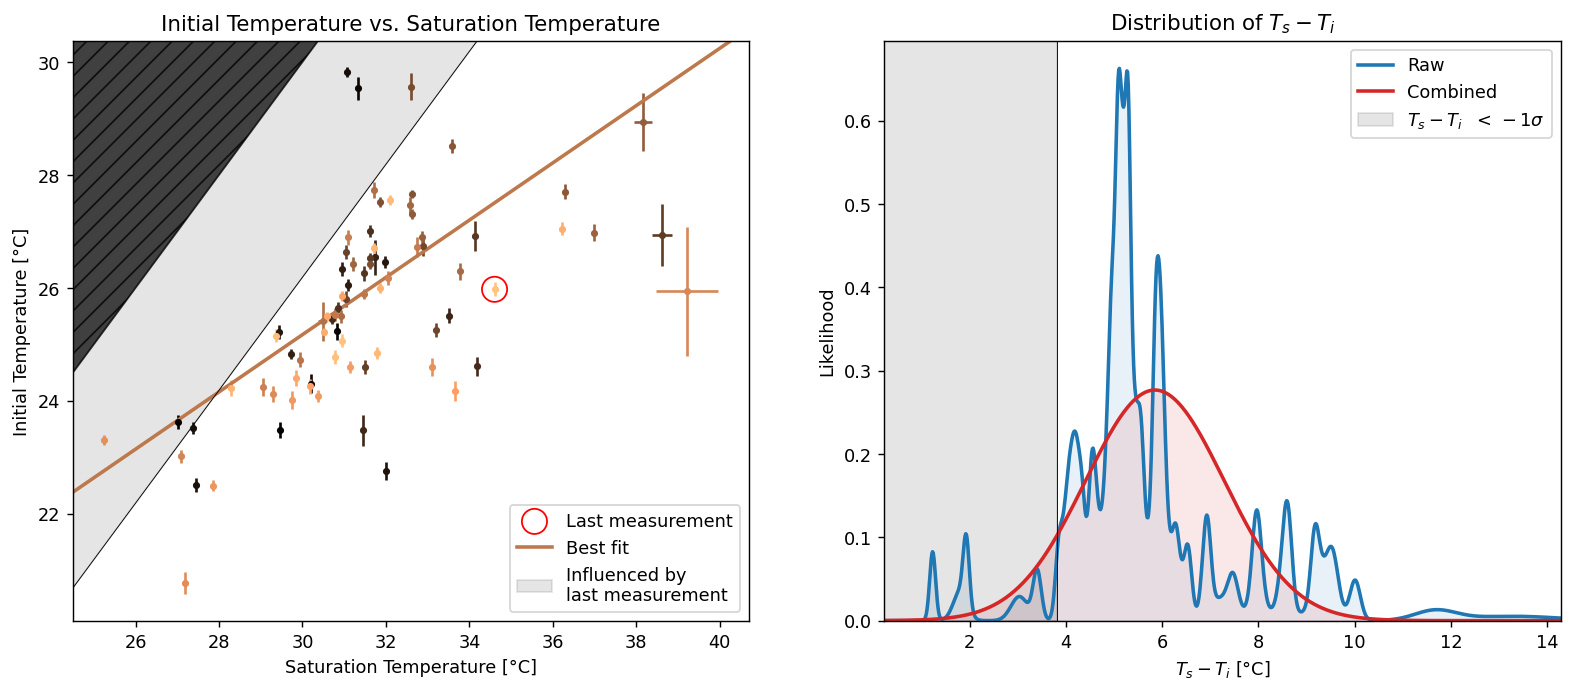

In [26]:
# Scatter the initial and saturatio ntemperature to see if there is a correlation
# Color the points from old to new (take the index) with a the virids colormap
fig, (ax_scatter, ax_hist) = plt.subplots(1, 2, figsize=(15, 6), dpi=128)
for i, color in enumerate([plt.cm.get_cmap('copper')(i / len(ti_good)) for i in range(len(ti_good))]):
    ax_scatter.errorbar(ts_good[i], ti_good[i], xerr=ts_good_err[i], yerr=ti_good_err[i], fmt='.', color=color)

# Indicate the last measurement with a red circle
ax_scatter.scatter(ts_good[-1], ti_good[-1], marker='o', facecolors='none', edgecolors='r', s=200, label='Last measurement')

xlim_before = ax_scatter.get_xlim()
ylim_before = ax_scatter.get_ylim()

line_xlim = xlim_before[0], xlim_before[1] + 1
ax_scatter.plot(np.arange(*line_xlim), intercept + slope * np.arange(*line_xlim), color=plt.cm.get_cmap('copper')(0.6), linewidth=2, label='Best fit')

# Plot the line where the initial temperature is equal to the saturation temperature
# ax_scatter.plot(np.arange(*line_xlim), np.arange(*line_xlim), color='k', alpha=0.1)

# Indicate the line and area where the difference between the saturation temperature and the initial temperature is equal to independent_measurement_min_delta
ax_scatter.plot(np.arange(*line_xlim), np.arange(*line_xlim) - independent_measurement_min_delta, color='k', linewidth=0.5)
ax_scatter.fill_between(np.arange(*line_xlim), np.arange(*line_xlim) - independent_measurement_min_delta, np.arange(*line_xlim), color='k', alpha=0.1, label='Influenced by\nlast measurement')

# Indicate unphysical temperature differences
ax_scatter.fill_between(np.arange(*line_xlim), np.arange(*line_xlim), np.arange(*line_xlim) + 10, color='k', alpha=0.75, hatch='//')

# Label the axes
ax_scatter.set_xlabel('Saturation Temperature [°C]')
ax_scatter.set_ylabel('Initial Temperature [°C]')
ax_scatter.set_title('Initial Temperature vs. Saturation Temperature')
ax_scatter.set_xlim(xlim_before)
ax_scatter.set_ylim(ylim_before)
ax_scatter.legend(loc='lower right')

# Plot the distribution of differences
ax_hist.plot(*delta_ts_ti_distribution, color='tab:blue', linewidth=2, label='Raw')
ax_hist.fill_between(*delta_ts_ti_distribution, color='tab:blue', alpha=0.1)

ax_hist.plot(*delta_ts_ti_mean_distribution, color='tab:red', linewidth=2, label='Combined')
ax_hist.fill_between(*delta_ts_ti_mean_distribution, color='tab:red', alpha=0.1)

# Inicate the line and area where the difference between the saturation temperature and the initial temperature is equal to independent_measurement_min_delta
ax_hist.axvline(independent_measurement_min_delta, color='k', linewidth=0.5)
ax_hist.axvspan(0, independent_measurement_min_delta, color='k', alpha=0.1, label='$T_s - T_i\,\,\,\,<\,-1 \sigma$')

ax_hist.set_xlabel('$T_s - T_i$ [°C]')
ax_hist.set_ylabel('Likelihood')
ax_hist.set_title('Distribution of $T_s - T_i$')
ax_hist.set_xlim(min(delta_ts_ti_distribution[0]), max(delta_ts_ti_distribution[0]))
ax_hist.set_ylim(0, None); ax_hist.legend(loc='upper right');

### Filter 2: Temperature Difference

In [27]:
# Pick out the instances where the difference between the saturation temperature and the initial temperature is higher than independent_measurement_min_delta
filter2_mask = delta_ts_ti > independent_measurement_min_delta
startup_temperature = ti_good[filter2_mask]
startup_temperature_err = ti_good_err[filter2_mask]

### Mean Room Temperature

In [28]:
def weighted_mean_and_uncertainty(x_list, x_err_list):
    x_var = 1 / np.sum(1 / x_err_list**2)
    x_weighted_mean = x_var * np.sum(x_list / x_err_list**2)
    return x_weighted_mean, np.sqrt(x_var)

In [29]:
# Aproximate the room temperature by the median of the liquid temperature at the start of each measurement
# Compute the weighted mean using the uncertainties
# The weight is the inverse of the the uncertainty in terms of its standard deviation
room_temperature, room_temperature_mean_err = weighted_mean_and_uncertainty(startup_temperature, startup_temperature_err)
room_temperature_err = np.std(startup_temperature, ddof=1)

print(f'Room temperature: {room_temperature:.1f} ± {room_temperature_err:.1f} °C')

Room temperature: 25.7 ± 1.5 °C


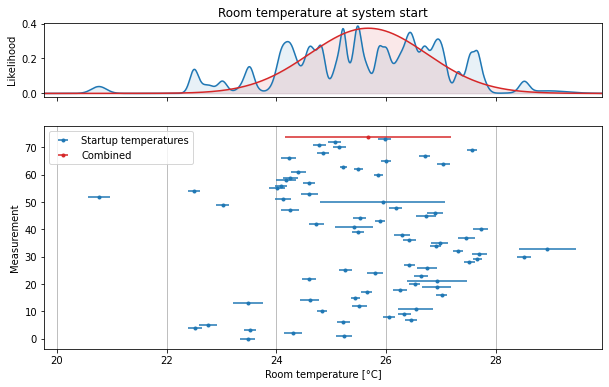

In [30]:
# Plot all instances of the startup temperature and its uncertainty
# Make the upper axis smaller than the lower axis
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [1, 3]})

individual_distribution = additive_distribution(startup_temperature, startup_temperature_err, 1000, xlim=(startup_temperature.min() - 1, startup_temperature.max() + 1))
axes[0].plot(*individual_distribution, color='tab:blue')
axes[0].fill_between(*individual_distribution, color='tab:blue', alpha=0.1)
mean_distribution = additive_distribution([room_temperature], [room_temperature_err], 1000, xlim=(startup_temperature.min() - 1, startup_temperature.max() + 1))
axes[0].plot(*mean_distribution, color='tab:red')
axes[0].fill_between(*mean_distribution, color='tab:red', alpha=0.1)
axes[0].set_xlim(startup_temperature.min() - 1, startup_temperature.max() + 1)
axes[0].set_title('Room temperature at system start')
axes[0].set_ylabel('Likelihood')

axes[1].errorbar(startup_temperature, np.arange(len(startup_temperature)), xerr=startup_temperature_err, fmt='.', label='Startup temperatures')
# Show the combined startup temperature and its uncertainty
axes[1].errorbar(room_temperature, len(startup_temperature), xerr=room_temperature_err, fmt='.', color='tab:red', label='Combined')
axes[1].set_xlim(startup_temperature.min() - 1, startup_temperature.max() + 1)
axes[1].legend(loc='upper left'); axes[1].grid(axis='x')
axes[1].set_xlabel('Room temperature [°C]')
axes[1].set_ylabel('Measurement');

## Weather Correlation

In [31]:
# Find the indices in the dataframe of the used measurements
dataframe_indices_masked = pause_indices[filter1_mask][filter2_mask]

# Get the time of the beginning of the measurements
timestamp_beginning_of_measurements = df.loc[dataframe_indices_masked, 'Timestamp'].values

# Convert the timestamp into a datetime object
time_beginning_of_measurements = pd.to_datetime(timestamp_beginning_of_measurements * 1e9, utc=True)

# Format the datetimes into YYYY-MM-DD
time_beginning_of_measurements = [datetime.datetime.strftime(x, '%Y-%m-%d') for x in time_beginning_of_measurements]

### Room Tempearture GP

In [32]:
# Apply min-max scaling to the time
time_scaler = MinMaxScaler()
timestamp_beginning_of_measurements_min_max = time_scaler.fit_transform(timestamp_beginning_of_measurements.reshape(-1, 1))

# Fit a gaussian process to the room temperature over time
gp = GaussianProcessRegressor(kernel=1 * Matern(), n_restarts_optimizer=10, alpha=startup_temperature_err**2, normalize_y=True)
gp.fit(timestamp_beginning_of_measurements_min_max, startup_temperature)

print(f'Score: {gp.score(timestamp_beginning_of_measurements_min_max, startup_temperature):.3f}')
print('Kernel:', gp.kernel_)

Score: 0.992
Kernel: 0.961**2 * Matern(length_scale=0.00625, nu=1.5)


### Weather Temperature GP

In [33]:
weather_df = load_weather_df()
weather_df = preprocess_weather_df(weather_df)
gp_weather, mm_weather = interpolate_temperature(weather_df)
gp_weather.kernel_

1.02**2 * Matern(length_scale=0.427, nu=1.5)

### Interpolate

In [34]:
temperatures, temperatures_err = get_temperature(timestamp_beginning_of_measurements, gp_weather, mm_weather, n_jobs=-1)
nan_mask = np.isnan(temperatures)

In [35]:
# Compare the liquid temperature at each time with the weather temperature
df['main.temp'], df['main.temp_err'] = get_temperature(df['Timestamp'], gp_weather, mm_weather, n_jobs=-1)

Predicting Temperatures using 8 workers: 100%|██████████| 1670/1670 [02:07<00:00, 13.09it/s]


### Temperature Plot

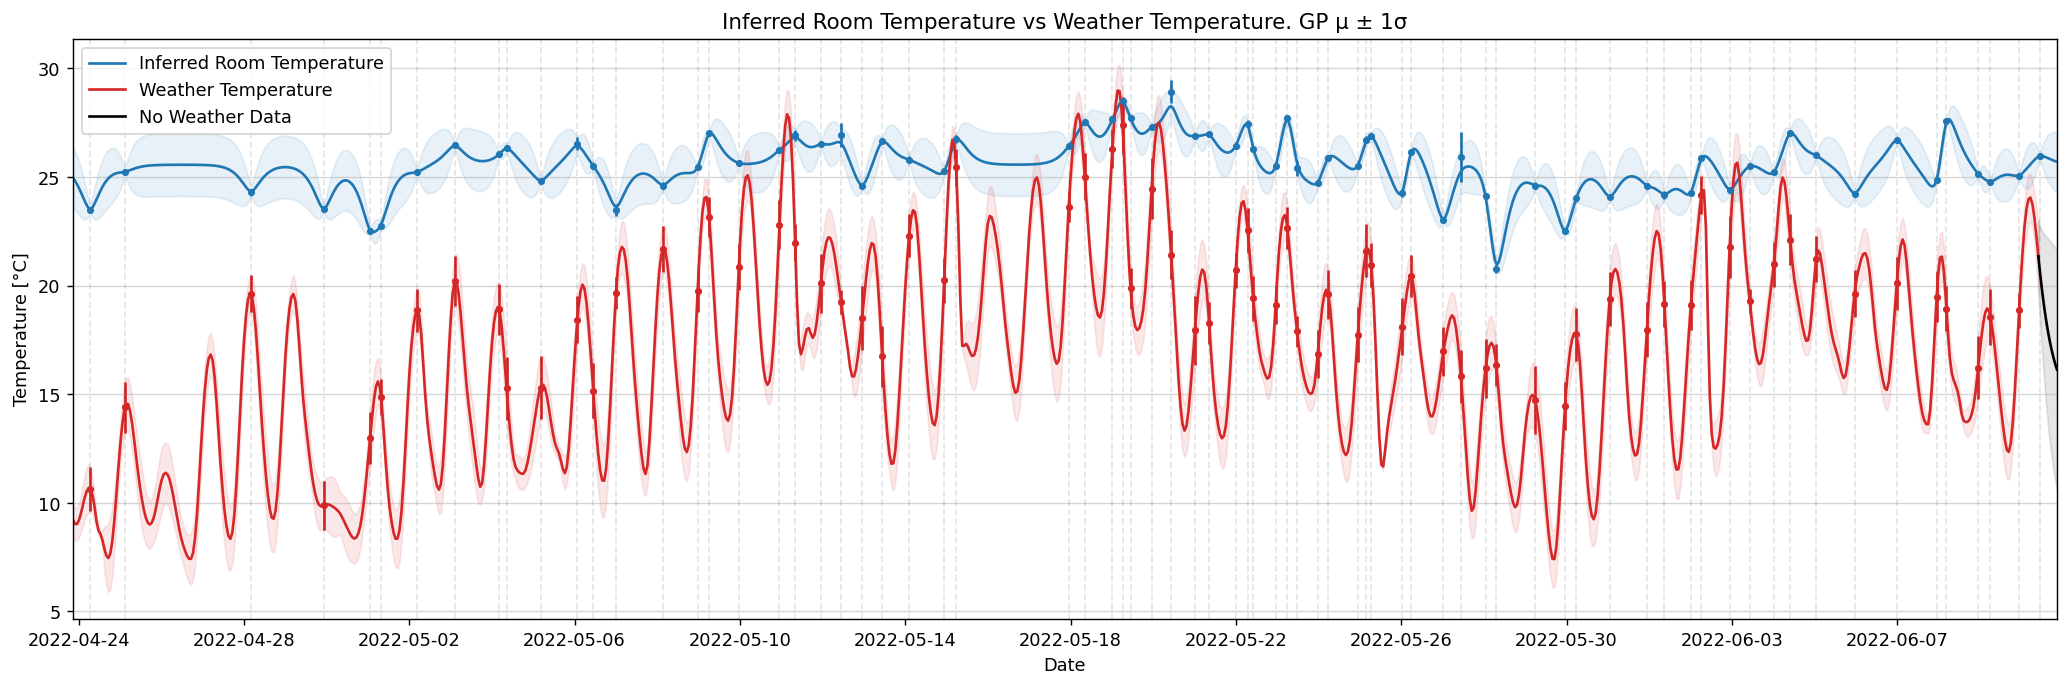

In [36]:
# Plot the startup temperature as a function of the time
fig, ax = plt.subplots(figsize=(20, 6), dpi=128)
ax.errorbar(timestamp_beginning_of_measurements, startup_temperature, yerr=startup_temperature_err, fmt='.', color='tab:blue')
ax.errorbar(timestamp_beginning_of_measurements, temperatures, yerr=temperatures_err, fmt='.', color='tab:red')

# Draw a vertical line at each measurement
for t in timestamp_beginning_of_measurements:
    ax.axvline(t, color='k', alpha=0.1, linestyle='--', linewidth=1)

padding = 3600 * 10
right_edge_timestamp = max(max(timestamp_beginning_of_measurements), max(weather_df['dt'])) + padding

# Plot the room GP prediction
time_linspace = np.linspace(min(timestamp_beginning_of_measurements) - padding, right_edge_timestamp, 1000)
gp_mean, gp_std = gp.predict(time_scaler.transform(time_linspace.reshape(-1, 1)), return_std=True)
ax.plot(time_linspace, gp_mean, color='tab:blue', label='Inferred Room Temperature')
ax.fill_between(time_linspace, gp_mean - gp_std, gp_mean + gp_std, color='tab:blue', alpha=0.1)

# Plot the weather GP prediction
time_linspace_strict = np.linspace(min(timestamp_beginning_of_measurements) - padding, max(weather_df['dt']), 1000)
gp_weather_mean, gp_weather_std = gp_weather.predict(mm_weather.transform(time_linspace_strict.reshape(-1, 1)), return_std=True)
ax.plot(time_linspace_strict, gp_weather_mean, color='tab:red', label='Weather Temperature')
ax.fill_between(time_linspace_strict, gp_weather_mean - gp_weather_std, gp_weather_mean + gp_weather_std, color='tab:red', alpha=0.1)

# Plot the weather GP prediction where no weather data is available yet
time_linspace_beyond = np.linspace(max(weather_df['dt']), right_edge_timestamp, 50)
gp_weather_mean, gp_weather_std = gp_weather.predict(mm_weather.transform(time_linspace_beyond.reshape(-1, 1)), return_std=True)
ax.plot(time_linspace_beyond, gp_weather_mean, color='k', label='No Weather Data')
ax.fill_between(time_linspace_beyond, gp_weather_mean - gp_weather_std, gp_weather_mean + gp_weather_std, color='k', alpha=0.1)


# Find the date of every n-th day since the start of the measurements
show_tick_every_n_days = 4

# The start time is the the day of the first measurement at 12:00
start_time = datetime.datetime.fromtimestamp(timestamp_beginning_of_measurements[0])
start_time = start_time.replace(hour=12, minute=0, second=0, microsecond=0)
start_timestamp = int(start_time.timestamp())

nth_days_time = np.arange(start_timestamp, right_edge_timestamp, show_tick_every_n_days * 86400)
nth_days_time_label = [datetime.datetime.strftime(datetime.datetime.fromtimestamp(t), '%Y-%m-%d') for t in nth_days_time]

# Label the axes
ax.set_xlabel('Date')
ax.set_ylabel('Temperature [°C]')
ax.set_title('Inferred Room Temperature vs Weather Temperature. GP µ ± 1σ');
ax.set_xticks(nth_days_time)
ax.set_xticklabels(nth_days_time_label)
ax.set_xlim(min(timestamp_beginning_of_measurements) - padding, right_edge_timestamp)
ax.grid(axis='y', alpha=0.5); ax.legend();

### Room Temperature Forecasting

In [37]:
# Find a model that predicts the room temperature based on one day of prior weather data

In [38]:
# Define the parameters
timestamp_inside_weather_df_mask = (timestamp_beginning_of_measurements >= weather_df.loc[0, 'dt']) & (timestamp_beginning_of_measurements <= weather_df.loc[len(weather_df) - 1, 'dt'])
n_hours_back = min(24, np.sum(timestamp_inside_weather_df_mask)-1)

# Find the indices of the input vectors using the indices of each start of a measurement using timestamp_beginning_of_measurements
weather_df_indices_beginning_of_measurements = np.searchsorted(weather_df['dt'], timestamp_beginning_of_measurements[timestamp_inside_weather_df_mask])

# One hour contains 1 measurement
weather_temperatures_input_indices = weather_df_indices_beginning_of_measurements[:, None] - np.arange(n_hours_back)[None, ::-1]

# Extract the weather temperatures from the weather dataframe
weather_temperatures_input = np.array(weather_df['main.temp'])[weather_temperatures_input_indices]

Score: 0.68
Intercept: 18.7


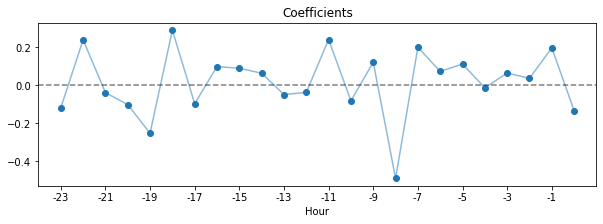

In [39]:
model = LinearRegression().fit(weather_temperatures_input, startup_temperature[timestamp_inside_weather_df_mask])

# Score the model
print(f'Score: {model.score(weather_temperatures_input, startup_temperature[timestamp_inside_weather_df_mask]):.2f}')
print(f'Intercept: {model.intercept_:.1f}')

# Plot the coefficients
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(np.arange(n_hours_back), model.coef_);
ax.plot(np.arange(n_hours_back), model.coef_, alpha=0.5);
ax.plot([-1, n_hours_back], [0]*2, alpha=0.5, color='k', linestyle='--');
ax.set_title('Coefficients');
ax.set_xlabel('Hour');
ax.set_xticks(np.arange(n_hours_back)[::2]); ax.set_xticklabels(-np.arange(n_hours_back)[::-2]);
ax.set_xlim(-1, n_hours_back);

### Correlation

In [40]:
# Use orthogonal distance regression to predict the Weather Temperature from the Room Temperature
from scipy import odr

In [41]:
# Fit function
def f(B, x):
    return B[0] * x + B[1]

# Define the model
model = odr.Model(f)

# Define the data
data = odr.RealData(startup_temperature[~nan_mask], temperatures[~nan_mask], sx=startup_temperature_err[~nan_mask], sy=temperatures_err[~nan_mask])

# Perform the fit
odr_fit = odr.ODR(data, model, beta0=[1, 0])

# Run the fit
odr_fit_result = odr_fit.run()

# Print the results
print(f'B0 = {odr_fit_result.beta[0]:.1f} ± {odr_fit_result.sd_beta[0]:.1f}')
print(f'B1 = {odr_fit_result.beta[1]:.1f} ± {odr_fit_result.sd_beta[1]:.1f}')

B0 = 1.5 ± 0.2
B1 = -19.3 ± 5.0


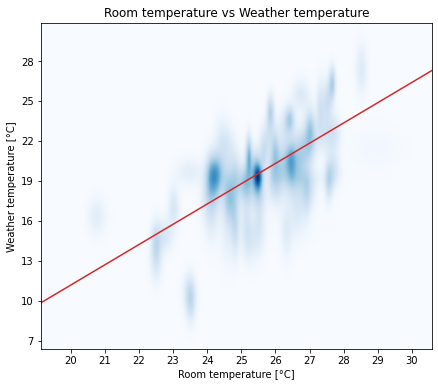

In [42]:
Z, (X, Y) = create_errorbar_densities(startup_temperature[~nan_mask], temperatures[~nan_mask], startup_temperature_err[~nan_mask], temperatures_err[~nan_mask], bins=1000, padding=0.2)
fig, ax = plt.subplots(figsize=(7, 6))
ax.pcolormesh(X, Y, Z, cmap=plt.cm.get_cmap('Blues'));

# ax.errorbar(startup_temperature[~nan_mask], temperatures[~nan_mask], xerr=startup_temperature_err[~nan_mask], yerr=temperatures_err[~nan_mask], fmt='.', color='white', linewidth=1)
# Plot the fitted line
xlim = ax.get_xlim()
ylim = ax.get_ylim()

startup_temperature_linspace = np.linspace(min(startup_temperature) - 2, max(startup_temperature) + 2, 100)
ax.plot(startup_temperature_linspace, f(odr_fit_result.beta, startup_temperature_linspace), color='tab:red')

ax.set_xlim(xlim); ax.set_ylim(ylim)
ax.set_xticks(np.arange(20, 31)); ax.set_yticks(np.arange(7, 31, 3));
ax.set_xlabel('Room temperature [°C]')
ax.set_ylabel('Weather temperature [°C]')
ax.set_title('Room temperature vs Weather temperature');

In [43]:
# Compute the correlation coefficient
corr_coef = np.corrcoef(startup_temperature[~nan_mask], temperatures[~nan_mask])[0, 1]
print(f'Correlation coefficient: {corr_coef:.3f}')

Correlation coefficient: 0.633


### 2D Histogram

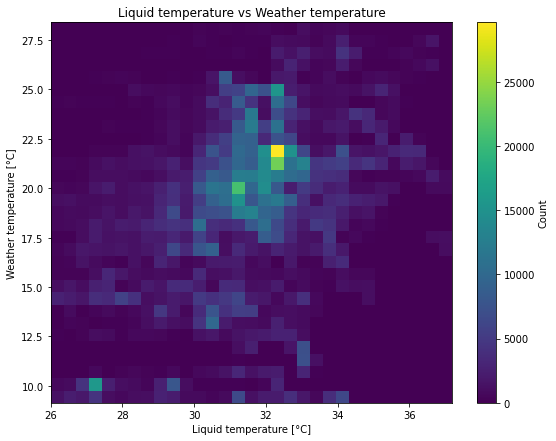

In [44]:
# Create a 2D histogram of the liquid temperature vs the weather temperature at all times
fig, ax = plt.subplots(figsize=(9, 7))
nan_mask = np.isnan(df['main.temp'])
n_bins = 32
bins = (np.linspace(26, max(df['Liquid Temperature [°C]']), n_bins), np.linspace(min(df['main.temp']), max(df['main.temp']), n_bins))
img = ax.hist2d(df['Liquid Temperature [°C]'][~nan_mask], df['main.temp'][~nan_mask], bins=bins);
ax.set_xlabel('Liquid temperature [°C]')
ax.set_ylabel('Weather temperature [°C]')
ax.set_title('Liquid temperature vs Weather temperature');

# Add a colorbar the same size as the histogram
cbar = fig.colorbar(img[3], ax=ax)
cbar.set_label('Count')